In [1]:
from collections import defaultdict
import os
import random
import time
from dataclasses import dataclass
from typing import Optional

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tyro
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter

# ManiSkill specific imports
import mani_skill.envs
from mani_skill.utils import gym_utils
# from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper, FlattenRGBDObservationWrapper
from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper
from mani_skill.utils.wrappers.record import RecordEpisode
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv

import copy
from typing import Dict
from mani_skill.envs.sapien_env import BaseEnv
from mani_skill.utils import common

class FlattenRGBDObservationWrapper(gym.ObservationWrapper):
    """
    Flattens the rgbd mode observations into a dictionary with two keys, "rgbd" and "state"

    Args:
        rgb (bool): Whether to include rgb images in the observation
        depth (bool): Whether to include depth images in the observation
        state (bool): Whether to include state data in the observation
    """

    def __init__(self, env, rgb=True, depth=True, state=True) -> None:
        self.base_env: BaseEnv = env.unwrapped
        super().__init__(env)
        self.include_rgb = rgb
        self.include_depth = depth
        self.include_state = state
        new_obs = self.observation(self.base_env._init_raw_obs)
        self.base_env.update_obs_space(new_obs)

    def observation(self, observation: Dict):
        # Save cup_with_ball_number if it exists
        cup_with_ball_number = observation.get('cup_with_ball_number', None)
        
        sensor_data = observation.pop("sensor_data")
        # print("Available cameras:", list(sensor_data.keys())) 
        # Available cameras: ['base_camera', 'hand_camera']
        del observation["sensor_param"]
        images = []
        for cam_data in sensor_data.values():
            if self.include_rgb:
                images.append(cam_data["rgb"])
            if self.include_depth:
                images.append(cam_data["depth"])

        images = torch.concat(images, axis=-1)
        # flatten the rest of the data which should just be state data
        observation = common.flatten_state_dict(
            observation, use_torch=True, device=self.base_env.device
        )
        ret = dict()
        if self.include_state:
            ret["state"] = observation
        if self.include_rgb and not self.include_depth:
            ret["rgb"] = images
        elif self.include_rgb and self.include_depth:
            ret["rgbd"] = images
        elif self.include_depth and not self.include_rgb:
            ret["depth"] = images
            
        # Add back cup_with_ball_number if it existed
        if cup_with_ball_number is not None:
            ret["cup_with_ball_number"] = cup_with_ball_number
            
        return ret

In [2]:
from ppo_rgb_shell_game import Agent, Args

import h5py
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

args = Args()
args.env_id = "ShellGamePush-v2"

if args.env_id == "ShellGamePush-v1":
    from shell_game_push import ShellGamePush, ColorObservationWrapper, InitialZeroActionWrapper, RenderStepInfoWrapper
elif args.env_id == "ShellGamePush-v2":
    from shell_game_push import ShellGamePush_v2 as ShellGamePush, ColorObservationWrapper, InitialZeroActionWrapper, RenderStepInfoWrapper
elif args.env_id == "ShellGamePick-v1":
    from shell_game_pick import ShellGamePick, ColorObservationWrapper, InitialZeroActionWrapper, RenderStepInfoWrapper 
elif args.env_id == "ShellGamePick-v2":
    from shell_game_pick import ShellGamePick_v2 as ShellGamePick, ColorObservationWrapper, InitialZeroActionWrapper, RenderStepInfoWrapper
elif args.env_id == "ShellGamePushBall-v2":
    from shell_game_push import ShellGamePushBall_v2 as ShellGamePushBall, ColorObservationWrapper, InitialZeroActionWrapper, RenderStepInfoWrapper 
elif args.env_id == "ShellGamePickBall-v2":
    from shell_game_pick import ShellGamePickBall_v2 as ShellGamePickBall, ColorObservationWrapper, InitialZeroActionWrapper, RenderStepInfoWrapper 

args.render_mode = "all"
args.include_state = True  # Enable state features since checkpoint uses them
args.num_envs = 512
args.update_epochs = 8
args.num_minibatches = 32
args.total_timesteps = 20_000_000
args.eval_freq = 10
args.num_steps = 90
args.evaluate = True
args.num_eval_envs = 8
args.cuda = True
args.num_eval_steps = 90
args.do_noops = False

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
print(device)

# Load checkpoint
checkpoint_path = "./runs/rgb-shellgamepush-v2-no-noops-num-steps-90-t-90/ckpt_21.pt"
checkpoint = torch.load(checkpoint_path)
# eval_output_dir = "./runs/rgb-pushcube/test_videos/"
eval_output_dir = "./dataset_shellgamepush_v2"
env_kwargs = dict(obs_mode="rgb", control_mode="pd_joint_delta_pos", render_mode=args.render_mode, sim_backend="gpu")

    
eval_envs = gym.make(args.env_id, num_envs=args.num_eval_envs, **env_kwargs) # , reconfigure_freq=args.eval_reconfiguration_freq
eval_envs = ColorObservationWrapper(eval_envs)
if args.do_noops:
    eval_envs = InitialZeroActionWrapper(eval_envs, n_initial_steps=34)
eval_envs = RenderStepInfoWrapper(eval_envs)

cuda
There are less parallel environments than total available models to sample.
                Not all models will be used during interaction even after resets unless you call env.reset(options=dict(reconfigure=True))
                or set reconfiguration_freq to be >= 1.


/opt/conda/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cup_with_ball_number to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cup_with_ball_number` for environment variables or `env.get_wrapper_attr('cup_with_ball_number')` that will search the reminding wrappers.
  logger.warn(


In [3]:
# num_envs = 512 # 512 * 8 = 4096

# for trajectory in tqdm(range(1, num_envs)):

#     # eval_envs = gym.make(args.env_id, num_envs=args.num_eval_envs, **env_kwargs)
#     eval_envs = gym.make(args.env_id, num_envs=args.num_eval_envs, **env_kwargs) # , reconfigure_freq=args.eval_reconfiguration_freq
#     eval_envs = ColorObservationWrapper(eval_envs)
#     if args.do_noops:
#         eval_envs = InitialZeroActionWrapper(eval_envs, n_initial_steps=34)
#     eval_envs = RenderStepInfoWrapper(eval_envs)


#     eval_envs = FlattenRGBDObservationWrapper(eval_envs, rgb=True, depth=False, state=args.include_state)
#     eval_envs = RecordEpisode(eval_envs, output_dir=eval_output_dir, save_trajectory=args.evaluate, 
#                               trajectory_name=f"trajectory_{trajectory}", max_steps_per_video=args.num_eval_steps, video_fps=30)
#     eval_envs = ManiSkillVectorEnv(eval_envs, args.num_eval_envs, ignore_terminations=True, record_metrics=True)

#     eval_obs, _ = eval_envs.reset()

#     agent = Agent(eval_envs, sample_obs=eval_obs).to(device)
#     agent.load_state_dict(checkpoint)

#     # Validate by running one episode
#     obs, _ = eval_envs.reset()
#     obs = {k: v.to(device).float() for k, v in obs.items()}

#     for _ in range(90):
#         action = agent.get_action(obs).to(device)
#         obs, reward, terminated, truncated, info = eval_envs.step(action)
#         done = torch.logical_or(terminated, truncated).to(torch.float32)

#     eval_envs.close()

<KeysViewHDF5 ['traj_0', 'traj_1', 'traj_2', 'traj_3', 'traj_4', 'traj_5', 'traj_6', 'traj_7']>
<KeysViewHDF5 ['obs', 'actions', 'terminated', 'truncated', 'success', 'env_states', 'rewards']>
actions (90, 8)
obs_keys <KeysViewHDF5 ['state', 'rgb', 'cup_with_ball_number']>
obs (91, 128, 128, 6)
done (90,)
success (90,)
rewards (90,)


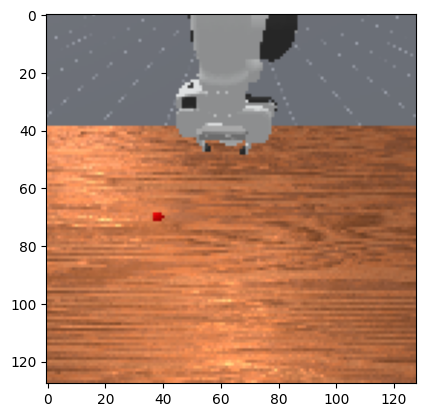

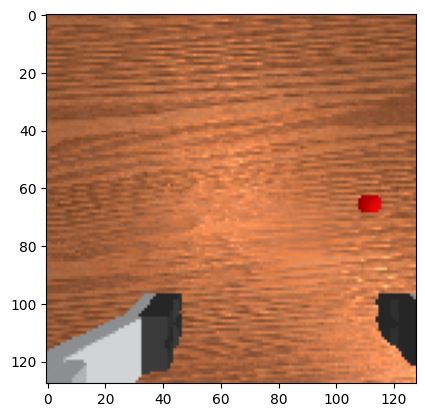

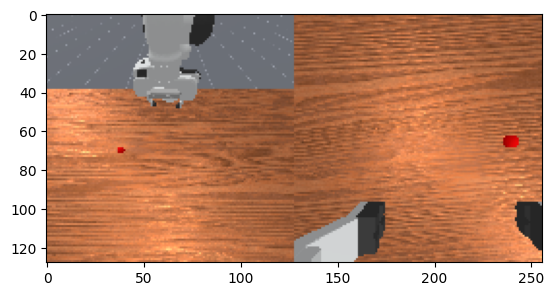

In [13]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

with h5py.File("./dataset_shellgamepush_v2/trajectory_135.h5", "r") as f:
    # Print available trajectories
    print(f.keys())
    traj = f["traj_0"]
    print(traj.keys())
    print("actions", traj["actions"].shape)
    print("obs_keys", traj["obs"].keys())
    print("obs", traj["obs"]["rgb"][()].shape)
    print('done', np.logical_or(traj["terminated"][()], traj["truncated"][()]).shape)

    print('success', traj["success"][()].shape)
    
    print('rewards', traj["rewards"][()].shape)
    plt.imshow(traj["obs"]["rgb"][()][0][:,:,0:3]) # -1 -- last frame
    plt.show()

    plt.imshow(traj["obs"]["rgb"][()][0][:,:,3:6]) # -1 -- last frame
    plt.show()

    stacked_obs = np.concatenate([traj["obs"]["rgb"][()][0][:,:,0:3], traj["obs"]["rgb"][()][0][:,:,3:6]], axis=1)
    plt.imshow(stacked_obs)
    plt.show()

In [14]:
num_envs = 512 # 512 * 8 = 4096

for trajectory in tqdm(range(1, num_envs)):

    # eval_envs = gym.make(args.env_id, num_envs=args.num_eval_envs, **env_kwargs)
    eval_envs = gym.make(args.env_id, num_envs=args.num_eval_envs, **env_kwargs) # , reconfigure_freq=args.eval_reconfiguration_freq
    eval_envs = ColorObservationWrapper(eval_envs)
    if args.do_noops:
        eval_envs = InitialZeroActionWrapper(eval_envs, n_initial_steps=34)
    eval_envs = RenderStepInfoWrapper(eval_envs)


    eval_envs = FlattenRGBDObservationWrapper(eval_envs, rgb=True, depth=False, state=args.include_state)
    eval_envs = ManiSkillVectorEnv(eval_envs, args.num_eval_envs, ignore_terminations=True, record_metrics=True)

    eval_obs, _ = eval_envs.reset()

    agent = Agent(eval_envs, sample_obs=eval_obs).to(device)
    agent.load_state_dict(checkpoint)

    # Validate by running one episode
    obs, _ = eval_envs.reset()
    obs = {k: v.to(device).float() for k, v in obs.items()}

    for _ in range(90):
        action = agent.get_action(obs).to(device)
        obs, reward, terminated, truncated, info = eval_envs.step(action)
        done = torch.logical_or(terminated, truncated).to(torch.float32)

    eval_envs.close()
    break

  0%|          | 0/511 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cup_with_ball_number to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cup_with_ball_number` for environment variables or `env.get_wrapper_attr('cup_with_ball_number')` that will search the reminding wrappers.
  logger.warn(
/opt/conda/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrappers.
  logger.warn(
/opt/conda/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_action_space to get variables from other wrappers is deprecated and will be removed

state in sample_obs


  0%|          | 0/511 [00:25<?, ?it/s]


In [19]:
obs['rgb'].shape

torch.Size([8, 128, 128, 6])

In [42]:
import os
import numpy as np
from tqdm import tqdm

npz_dir = "../ManiSkill/dataset_shellgamepush_v2_single_h5"
data_n = 1
data_sum = 0
data_sum_lst = []
for filename in tqdm(os.listdir(npz_dir)):
    if filename.endswith('.npz'):
        file_path = os.path.join(npz_dir, filename)
        with np.load(file_path, allow_pickle=False) as data:
            
            r = data['r'].copy()
            r[r != 1] = 0 # ! for sparse_reward setting
        
            data_sum += r.sum()
            data_sum_lst.append(r.sum())
            data_n += 1
            # break

100%|██████████| 4096/4096 [00:02<00:00, 1407.46it/s]


In [43]:
# Sort data_sum_lst in descending order
sorted_data = sorted(data_sum_lst, reverse=True)
print("Top 10 highest returns:", sorted_data[:10])
print("Mean:", np.mean(sorted_data[:10]))
print("Bottom 10 lowest returns:", sorted_data[-10:])

Top 10 highest returns: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Mean: 0.6
Bottom 10 lowest returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [44]:
# dense: 14.42
# sparse: 0.6